# 0. Import and settings

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import scanpy_scripts as ss
import phate

expr_cmap = ss.lib.expression_colormap()
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
sc.settings.figdir = 'png'

# 1. Load data

In [3]:
h5ad_dir = '../data/h5ad/20191205'

In [4]:
h1_categories = ['melanocytes', 'erythroid', 'keratinocytes', 'mast_cells', 'lymphoid_B', 'endothelium', 'lymphoid_T_NK', 'myeloid', 'stroma']

In [5]:
h2_categories = ['neutrophiles']

In [6]:
rachel_annot_tsv = '../data/misc/20200112_fetal_skin_rachel_annotation.tsv'

In [7]:
rachel_annot = pd.read_csv(rachel_annot_tsv, sep='\t')

In [8]:
rachel_annot.head()

,category,clustering,cluster_id,cluster_annot
0,stroma,leiden_hm_r0_4,0,Fibroblast
1,stroma,leiden_hm_r0_4,1,Fibroblast
2,stroma,leiden_hm_r0_4,2,Fibroblast
3,stroma,leiden_hm_r0_4,3,Fibroblast
4,stroma,leiden_hm_r0_4,5,Fibroblast


In [9]:
rachel_marker_tsv = '../data/misc/20200112_fetal_skin_rachel_markers.tsv'

In [10]:
rachel_marker = pd.read_csv(rachel_marker_tsv, sep='\t')

__Derive dotplot gene grouping positions:__

In [11]:
marker_group_index = rachel_marker.groupby('category').apply(
    lambda df: df.reset_index(drop=True)
).reset_index(level=1).rename(columns={'level_1': 'marker_order'}).reset_index(drop=True).groupby(['category', 'cluster_name']).apply(
    lambda df: (min(df.marker_order), max(df.marker_order))
).to_dict()

In [12]:
marker_group_index

{('endothelium', 'Lymphatic'): (6, 8),
 ('endothelium', 'Vascular'): (3, 5),
 ('erythroid', 'Early Erythroid I'): (2, 2),
 ('erythroid', 'Early Erythroid II'): (3, 4),
 ('erythroid', 'HBA Erythroid'): (7, 8),
 ('erythroid', 'Mid Erythroid'): (5, 6),
 ('erythroid', 'YS Erythroid'): (0, 1),
 ('keratinocytes', 'Basal KC'): (3, 5),
 ('keratinocytes', 'KC stem cell'): (6, 6),
 ('keratinocytes', 'Periderm'): (0, 2),
 ('keratinocytes', 'Suprabasal cell'): (7, 8),
 ('lymphoid_B', 'B cell'): (10, 13),
 ('lymphoid_B', 'Pre B cell'): (6, 9),
 ('lymphoid_B', 'Pre Pro B cell'): (0, 2),
 ('lymphoid_B', 'Pro B cell'): (3, 5),
 ('lymphoid_B', 'pDC'): (14, 16),
 ('lymphoid_T_NK', 'CD4 T cell'): (14, 19),
 ('lymphoid_T_NK', 'CD8 T cell'): (20, 21),
 ('lymphoid_T_NK', 'ILC2'): (26, 29),
 ('lymphoid_T_NK', 'LTi/ILC3'): (24, 25),
 ('lymphoid_T_NK', 'MLP'): (0, 2),
 ('lymphoid_T_NK', 'NK'): (3, 8),
 ('lymphoid_T_NK', 'NK T'): (9, 13),
 ('lymphoid_T_NK', 'Treg'): (22, 23),
 ('mast_cells', 'Eosinophil'): (9, 

__Read h5ads for each category:__

In [13]:
h1_ads = {}

for i, row in rachel_annot.iterrows():
    if row.category not in h1_ads:
        print(row.category)
        h1_ads[row.category] = sc.read(f'{h5ad_dir}/fetal_skin.{row.category}.processed.20191205.h5ad')
        ad = h1_ads[row.category]
        # Pull out MLP from cluster 7 for lymphoid_T_NK
        if row.category == 'lymphoid_T_NK':
            ss.lib.leiden(ad, use_graph='neighbors_hm', restrict_to=['leiden_hm_r0_4', ['7']], resolution=0.2, key_added='hm_r0_4_split')
        ad.obs['rachel_annot2'] = ad.obs[row.clustering].copy().astype(str)
    ad.obs.loc[ad.obs[row.clustering] == str(row.cluster_id), 'rachel_annot2'] = row.cluster_annot

for ct in h1_categories:
    cluster_names = list(rachel_annot.loc[rachel_annot.category == ct, 'cluster_annot'].unique())
    h1_ads[ct].obs['rachel_annot2'] = h1_ads[ct].obs['rachel_annot2'].astype('category').cat.reorder_categories(cluster_names)

stroma
Only considering the two last: ['.20191205', '.h5ad'].
Only considering the two last: ['.20191205', '.h5ad'].
myeloid
Only considering the two last: ['.20191205', '.h5ad'].
Only considering the two last: ['.20191205', '.h5ad'].
lymphoid_T_NK
Only considering the two last: ['.20191205', '.h5ad'].
Only considering the two last: ['.20191205', '.h5ad'].
endothelium
Only considering the two last: ['.20191205', '.h5ad'].
Only considering the two last: ['.20191205', '.h5ad'].
lymphoid_B
Only considering the two last: ['.20191205', '.h5ad'].
Only considering the two last: ['.20191205', '.h5ad'].
mast_cells
Only considering the two last: ['.20191205', '.h5ad'].
Only considering the two last: ['.20191205', '.h5ad'].
keratinocytes
Only considering the two last: ['.20191205', '.h5ad'].
Only considering the two last: ['.20191205', '.h5ad'].
erythroid
Only considering the two last: ['.20191205', '.h5ad'].
Only considering the two last: ['.20191205', '.h5ad'].
melanocytes
Only considering the 

In [ ]:
# # Correct annotation

# ad = h1_ads['myeloid']
# ad.obs['rachel_annot2'] = ad.obs['rachel_annot2'].astype(str)

# for i, row in rachel_annot.loc[rachel_annot.category=='myeloid'].iterrows():
#     ad.obs.loc[ad.obs[row.clustering] == str(row.cluster_id), 'rachel_annot2'] = row.cluster_annot
    
# for ct in ['myeloid']:
#     h1_ads[ct].obs['rachel_annot2'] = ad.obs['rachel_annot2'].astype('category')

__Remove cells labelled to be removed, e.g. doublets__

In [16]:
ads = {}

for ct in h1_categories:
    ad = h1_ads[ct]
    k_remove = ad.obs['rachel_annot2'].str.startswith('remove')
    ads[ct] = ad[~k_remove, :]

# 2. Make plots

### UMAPs

In [17]:
sc.set_figure_params(dpi=80, dpi_save=150)

In [19]:
ss.lib.set_figsize((4,4))
for ct in h1_categories:
    ad = ads[ct]
    if 'Unknown' in ad.obs.rachel_annot2.cat.categories and 'rachel_annot2_colors' in ad.uns.keys():
        i = np.where(ad.obs.rachel_annot2.cat.categories == 'Unknown')[0][0]
        ad.uns['rachel_annot2_colors'][i] = '#dddddd'
    ss.lib.plot_scatter(ad, basis='umap_hm', color=['rachel_annot2', 'pcw'], title=[f'{ct}, cell type', f'{ct}, pcw'], size=min(30, 120000/ad.shape[0]), wspace=0.6, save=f'_{ct}.png', show=False)

saving figure to file png/umap_hm_melanocytes.png
saving figure to file png/umap_hm_erythroid.png
saving figure to file png/umap_hm_keratinocytes.png
saving figure to file png/umap_hm_mast_cells.png
saving figure to file png/umap_hm_lymphoid_B.png
saving figure to file png/umap_hm_endothelium.png
saving figure to file png/umap_hm_lymphoid_T_NK.png
saving figure to file png/umap_hm_myeloid.png
saving figure to file png/umap_hm_stroma.png


### Dotplots

In [111]:
rachel_marker.loc[rachel_marker['category'] == 'endothelium', 'cluster_name'].unique()

array([nan, 'Vascular', 'Lymphatic'], dtype=object)

In [21]:
for ct in h1_categories:
    ad = ads[ct]
    genes = rachel_marker.loc[rachel_marker['category'] == ct, 'markers'].to_list()
    clusters = rachel_marker.loc[rachel_marker['category'] == ct, 'cluster_name'].unique().astype(str)
    grp_names = list(clusters[clusters != 'nan'])
    grp_pos = [marker_group_index[(ct, grp)] for grp in grp_names]
    sc.pl.dotplot(ad, var_names=genes, groupby='rachel_annot2', var_group_positions=grp_pos, var_group_labels=grp_names, var_group_rotation=90, save=f'_{ct}.png', show=False)

saving figure to file png/dotplot_melanocytes.png
saving figure to file png/dotplot_erythroid.png
saving figure to file png/dotplot_keratinocytes.png
saving figure to file png/dotplot_mast_cells.png
saving figure to file png/dotplot_lymphoid_B.png
saving figure to file png/dotplot_endothelium.png
saving figure to file png/dotplot_lymphoid_T_NK.png
saving figure to file png/dotplot_myeloid.png
saving figure to file png/dotplot_stroma.png


### Trajectories, PAGA

#### Keratinocytes

In [22]:
ad = ads['keratinocytes']

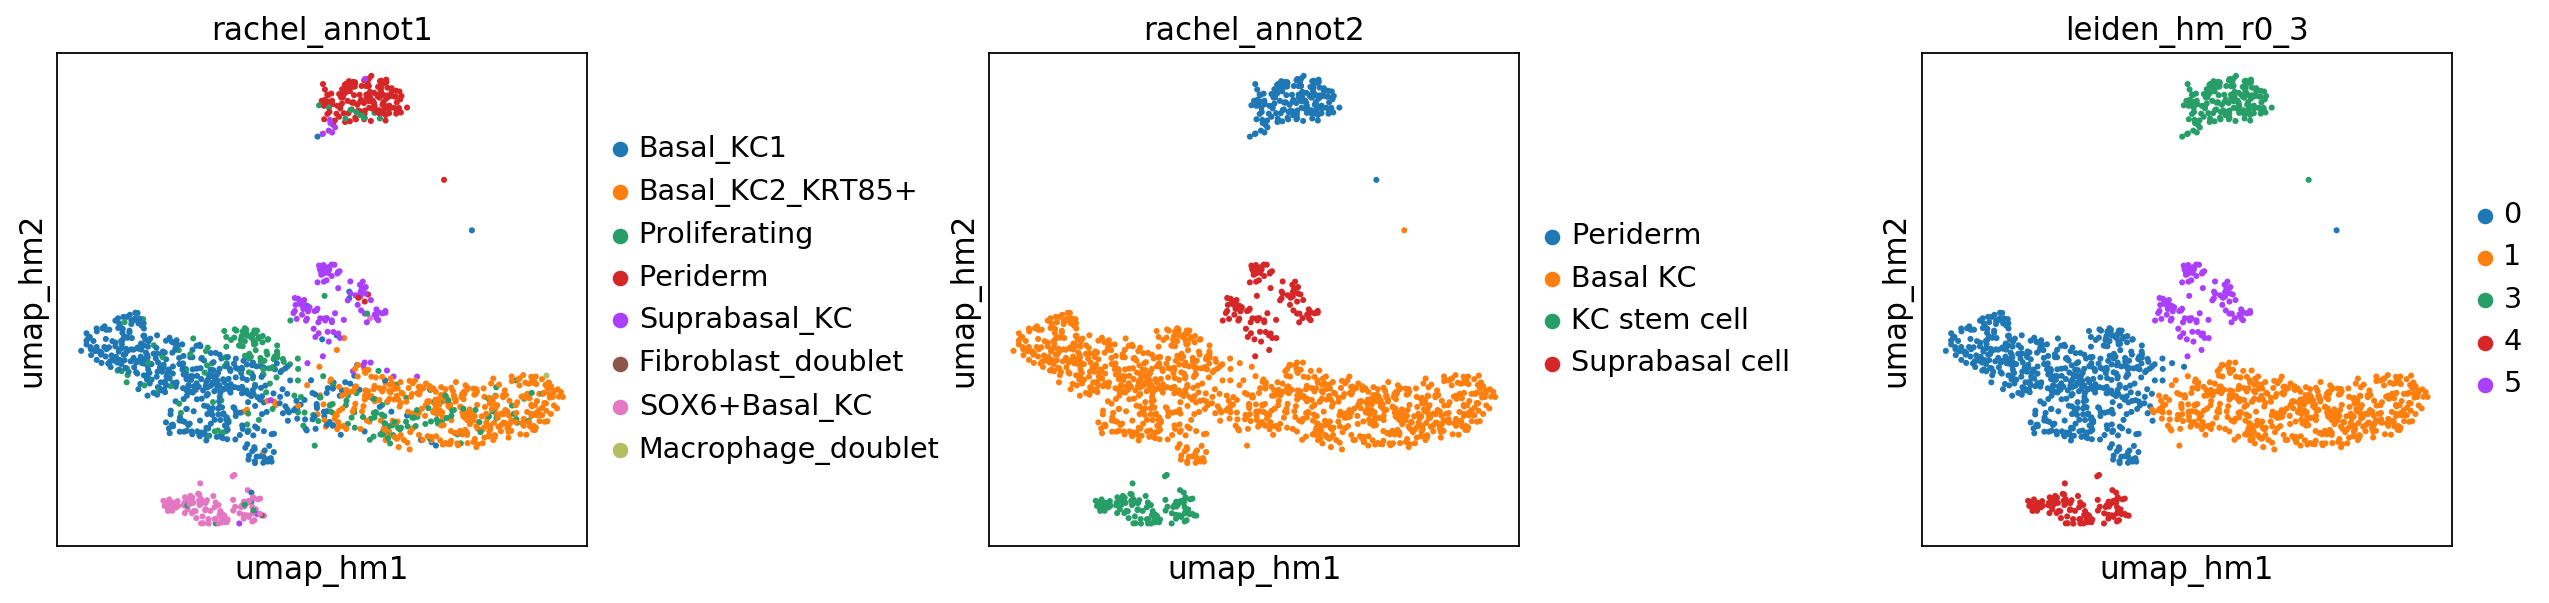

In [23]:
ss.lib.plot_scatter(ad, basis='umap_hm', color=['rachel_annot1', 'rachel_annot2', 'leiden_hm_r0_3'], size=30, wspace=0.6)

In [24]:
ad_kc = ad[(ad.obs['rachel_annot2'] != 'Periderm') & ~ad.obs['rachel_annot1'].isin(['Periderm', 'Macrophage_doublet', 'Fibroblast_doublet']), :].copy()

In [25]:
ss.lib.paga(ad_kc, use_graph='neighbors_hm', key_added='hm_rachel_annot1', groups='rachel_annot1')

AnnData object with n_obs × n_vars = 1301 × 17905 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'rachel_annot1', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'rachel_annot2'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_bk', 'neighbors_hm', 'pca', 'rachel_annot2_colors', 'rachel_annot1_colors', 'leiden_hm_r0_3_colors', 'rachel_annot1_sizes', 'paga_hm_rachel_annot1'
    obsm: 'X_pca', 'X_pca_hm', 'X_

saving figure to file png/paga_keratinocytes.png


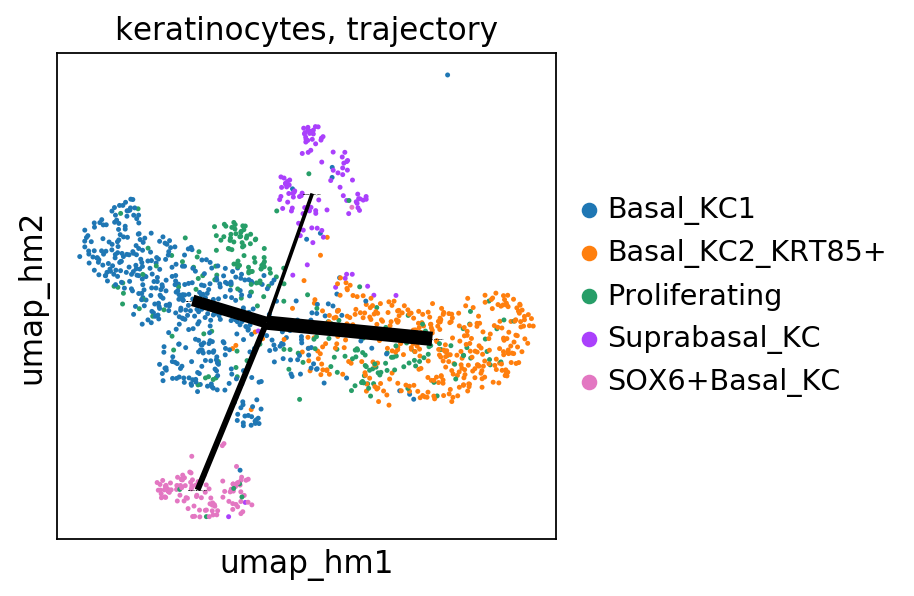

In [26]:
ss.lib.plot_paga(
    ad_kc, use_key='paga_hm_rachel_annot1', basis='umap_hm', color='rachel_annot1', solid_edges='connectivities_tree',
    size=20, legend_loc='right margin', title='keratinocytes, trajectory', save='_keratinocytes.png'
)

In [27]:
ss.lib.paga(ad_kc, use_graph='neighbors_hm', key_added='hm_rachel_annot2', groups='rachel_annot2')

AnnData object with n_obs × n_vars = 1301 × 17905 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'rachel_annot1', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'rachel_annot2'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_bk', 'neighbors_hm', 'pca', 'rachel_annot2_colors', 'rachel_annot1_colors', 'leiden_hm_r0_3_colors', 'rachel_annot1_sizes', 'paga_hm_rachel_annot1', 'rachel_annot2_sizes', 'paga_hm_r

saving figure to file png/paga_keratinocytes2.png


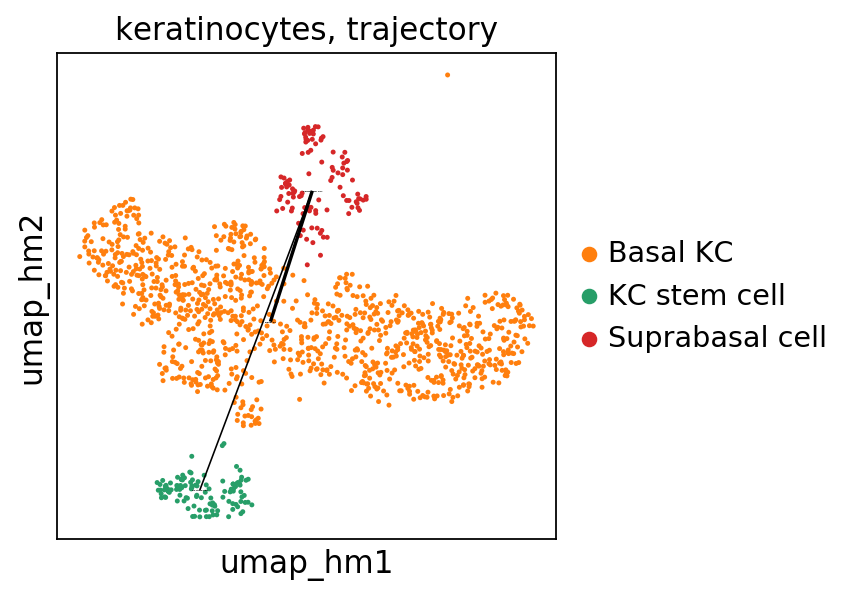

In [28]:
ss.lib.plot_paga(
    ad_kc, use_key='paga_hm_rachel_annot2', basis='umap_hm', color='rachel_annot2', solid_edges='connectivities_tree',
    size=20, edge_width_scale=2, legend_loc='right margin', title='keratinocytes, trajectory', save='_keratinocytes2.png'
)

#### Neutrophiles

In [29]:
mono = sc.read('../data/h5ad/fetal_skin_hierarch2_monocyte_processed.h5ad', backed=True)

In [30]:
mono

AnnData object with n_obs × n_vars = 11583 × 19878 backed at '../data/h5ad/fetal_skin_hierarch2_monocyte_processed.h5ad'
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_hm_r0_3_split4_r0_1', 'leiden_hm_r0_3_split4_r0_5', 'leiden_hm_r0_3_split4_r0_9', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_bk_r0_3_split4_r0_1', 'leiden_bk_r0_3_split4_r0_5', 'leiden_bk_r0_3_split4_r0_9', 'leiden_bk_r0_4_split4_r0_1', 'leiden_bk_r0_4_split4_r0_5', 'leiden_bk_r0_4_split4_r0_9', 'leide

In [31]:
k_neut = mono.obs.leiden_hm_r0_3_split4_r0_5.isin(['4,0', '4,1', '4,2'])

In [32]:
k_neut0 = mono.obs.leiden_hm_r0_3_split4_r0_5 == '4,0'

In [34]:
k_neut1 = mono.obs.leiden_hm_r0_3_split4_r0_5 == '4,2'

In [33]:
k_neut2 = mono.obs.leiden_hm_r0_3_split4_r0_5 == '4,1'

In [35]:
mono.obs.index[k_neut]

Index(['GACTAACCACAGACAG-1-4834STDY7002879',
       'CTTACCGGTAGAAGGA-1-4834STDY7002880',
       'AAAGTAGGTTTGACAC-1-FCAImmP7241240',
       'ACAGCCGGTTGGTAAA-1-FCAImmP7241240',
       'ACGCCGATCTGCTGCT-1-FCAImmP7241240',
       'ATGAGGGTCCCTTGTG-1-FCAImmP7241240',
       'CAACCAATCCGGCACA-1-FCAImmP7241240',
       'CCAATCCCACCTATCC-1-FCAImmP7241240',
       'CCACGGAAGAACTGTA-1-FCAImmP7241240',
       'CGATTGAAGCGATGAC-1-FCAImmP7241240',
       ...
       'GAGTCCGCATGAAGTA-1-FCAImmP7964507',
       'GCGCAACGTTCGGGCT-1-FCAImmP7964507',
       'TGTGGTAAGAATGTTG-1-FCAImmP7964507',
       'AGGCCACCACGGCCAT-1-FCAImmP7964510',
       'GCCTCTAGTACTTCTT-1-FCAImmP7964510',
       'GGGCATCGTGGTTTCA-1-FCAImmP7964510',
       'GTCACAAGTCTTCGTC-1-FCAImmP7964510',
       'TAAGCGTCACCCATGG-1-FCAImmP7964510',
       'TCAGGATGTAGCGCTC-1-FCAImmP7964510',
       'TGGACGCCAAGAGTCG-1-FCAImmP7964510'],
      dtype='object', name='index', length=233)

In [36]:
h2_ads = {}

In [37]:
h2_ads['neutrophiles'] = ads['myeloid'][ads['myeloid'].obs.index.isin(mono.obs.index[k_neut]), :].copy()

In [38]:
ads['neutrophiles'] = h2_ads['neutrophiles'][h2_ads['neutrophiles'].obs['rachel_annot2'] == 'Neut-myeloid precursor', :].copy()

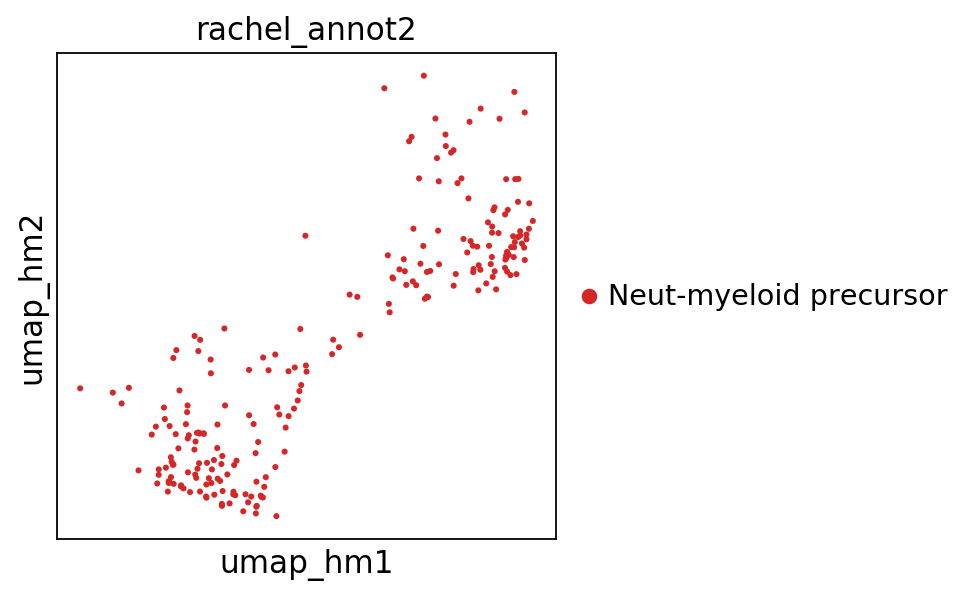

In [39]:
ss.lib.plot_scatter(ads['neutrophiles'], basis='umap_hm', color='rachel_annot2', size=30)

In [40]:
ad_np = ads['neutrophiles']

In [41]:
ad_np.obs['rachel_annot1'] = 'Unknown'
ad_np.obs.loc[ad_np.obs.index.isin(mono.obs.index[k_neut0]),'rachel_annot1'] = 'Neutrophile'
ad_np.obs.loc[ad_np.obs.index.isin(mono.obs.index[k_neut1]),'rachel_annot1'] = 'Neut-myeloid precursor 1'
ad_np.obs.loc[ad_np.obs.index.isin(mono.obs.index[k_neut2]),'rachel_annot1'] = 'Neut-myeloid precursor 2'

In [42]:
ss.lib.leiden(ad_np, use_graph='neighbors_hm', resolution=0.6, key_added='hm_split')

['leiden_hm_split']

In [43]:
ad_np.obs.loc[ad_np.obs['leiden_hm_split'] == '3', 'leiden_hm_split'] = '1'

In [44]:
ad_np.obs['rachel_annot2'] = ad_np.obs['leiden_hm_split'].cat.rename_categories({'0': 'Neutrophile', '1': 'Neut-myeloid precursor 1', '2': 'Neut-myeloid precursor 2', '3': 'Unknown'})
ad_np.obs['rachel_annot2'].cat.remove_unused_categories(inplace=True)

... storing 'rachel_annot1' as categorical


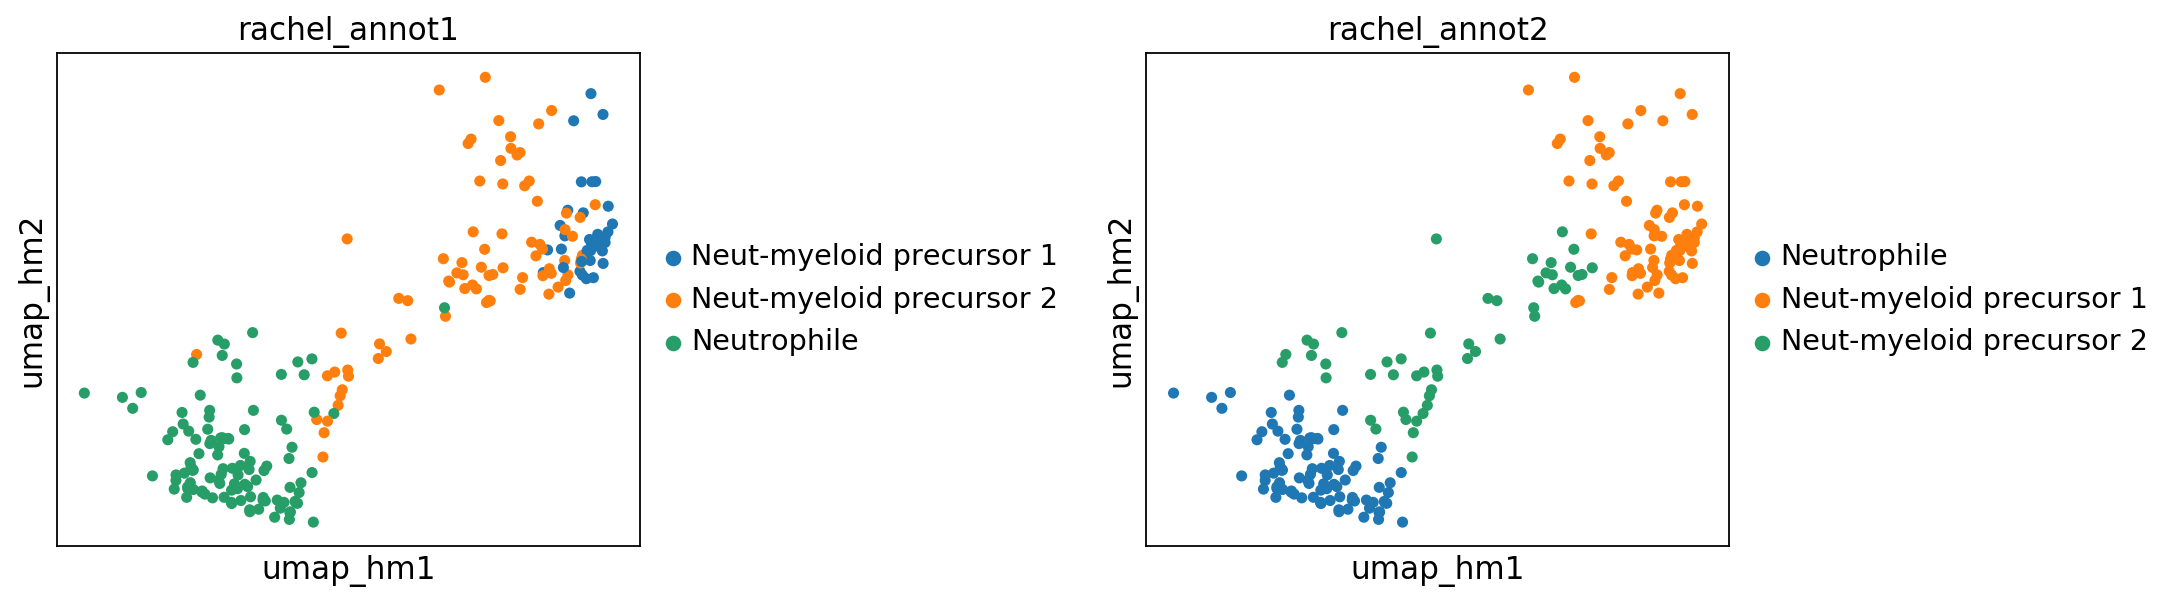

In [45]:
ss.lib.plot_scatter(ad_np, basis='umap_hm', color=['rachel_annot1', 'rachel_annot2'], size=100, wspace=0.7)

In [46]:
ss.lib.paga(ad_np, use_graph='neighbors_hm', key_added='hm_rachel_annot1', groups='rachel_annot1')
ss.lib.paga(ad_np, use_graph='neighbors_hm', key_added='hm_rachel_annot2', groups='rachel_annot2')

AnnData object with n_obs × n_vars = 224 × 23931 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'rachel_annot1', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'rachel_annot2', 'leiden_hm_split'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_bk', 'neighbors_hm', 'pca', 'rachel_annot2_colors', 'rachel_annot1_colors', 'rachel_annot1_sizes', 'paga_hm_rachel_annot1', 'rachel_annot2_sizes', 'paga_hm_rachel_a

saving figure to file png/paga_neutrophiles.png


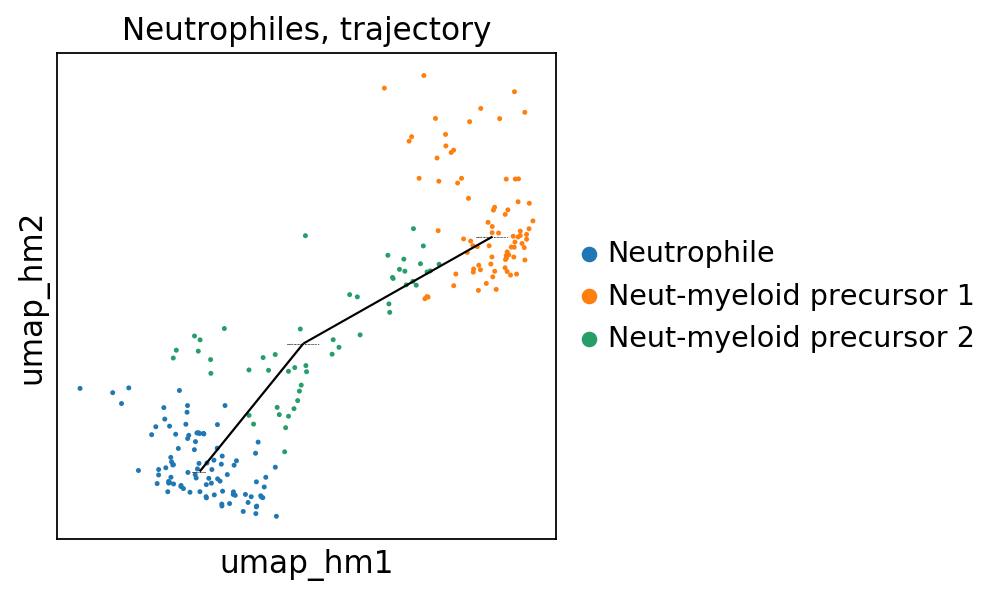

In [47]:
ss.lib.plot_paga(
    ad_np, use_key='paga_hm_rachel_annot2', basis='umap_hm', color='rachel_annot2', solid_edges='connectivities_tree',
    size=20, edge_width_scale=0.5, legend_loc='right margin', title='Neutrophiles, trajectory', save='_neutrophiles.png'
)

In [48]:
ad_np2 = ads['myeloid'][ads['myeloid'].obs['rachel_annot2'] == 'Neut-myeloid precursor', :].copy()

In [49]:
ad_np2.obs['rachel_annot1'] = 'Unknown'
ad_np2.obs.loc[ad_np2.obs.index.isin(mono.obs.index[k_neut0]),'rachel_annot1'] = 'Neutrophile'
ad_np2.obs.loc[ad_np2.obs.index.isin(mono.obs.index[k_neut1]),'rachel_annot1'] = 'Neut-myeloid precursor 1'
ad_np2.obs.loc[ad_np2.obs.index.isin(mono.obs.index[k_neut2]),'rachel_annot1'] = 'Neut-myeloid precursor 2'

In [50]:
ss.lib.leiden(ad_np2, use_graph='neighbors_hm', resolution=0.5, key_added='hm_split')

['leiden_hm_split']

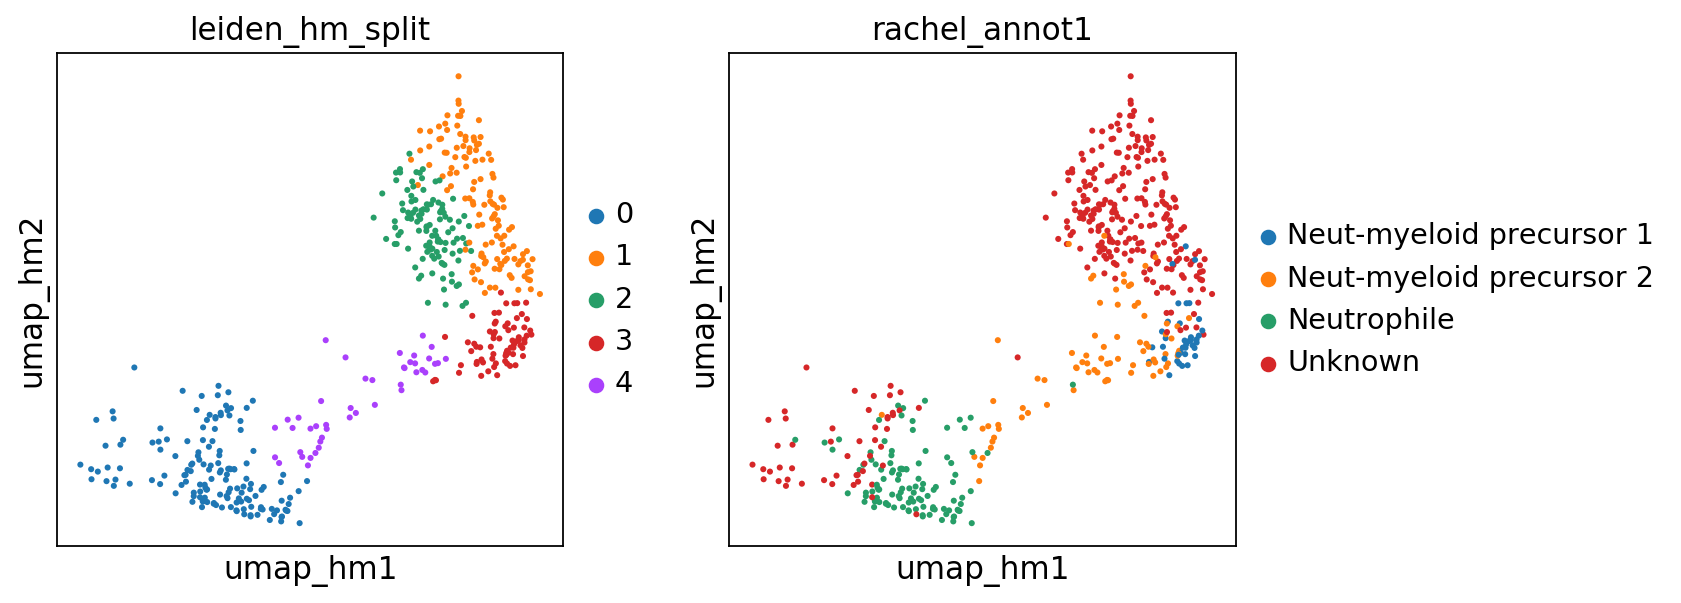

In [303]:
ss.lib.plot_scatter(ad_np2, basis='umap_hm', color=['leiden_hm_split', 'rachel_annot1'], size=30)

In [52]:
ss.lib.paga(ad_np2, use_graph='neighbors_hm', key_added='hm_split', groups='leiden_hm_split')

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


AnnData object with n_obs × n_vars = 509 × 23931 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'rachel_annot1', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'rachel_annot2', 'leiden_hm_split'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_bk', 'neighbors_hm', 'pca', 'rachel_annot2_colors', 'leiden_hm_split_colors', 'rachel_annot1_colors', 'leiden_hm_split_sizes', 'paga_hm_split'
    obsm: 'X_pca', 'X

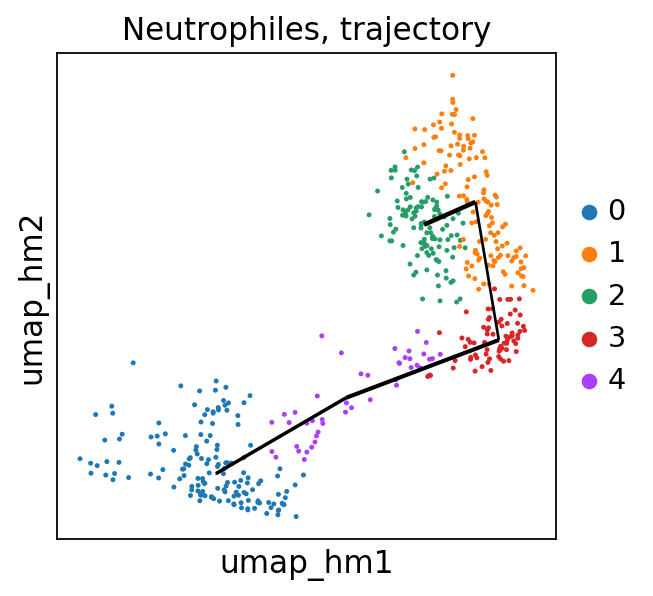

In [55]:
ss.lib.plot_paga(
    ad_np2, use_key='paga_hm_split', basis='umap_hm', color='leiden_hm_split', solid_edges='connectivities_tree',
    size=20, edge_width_scale=0.5, legend_loc='right margin', title='Neutrophiles, trajectory'#, save='_neutrophiles.png'
)

### Trajectories, PHATE

#### Keratinocytes

In [197]:
phate_operator = phate.PHATE(n_components=2, k=5, decay=20, t=500, n_pca=100, random_state=0)
kc_phate = phate_operator.fit_transform(ad_kc.obsm['X_pca_hm'])
ad_kc.obsm['X_phate_hm'] = kc_phate

Calculating PHATE...
  Running PHATE on 1301 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.12 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.15 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.29 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.81 seconds.
Calculated PHATE in 2.26 seconds.


saving figure to file png/phate_hm_keratinocytes.png


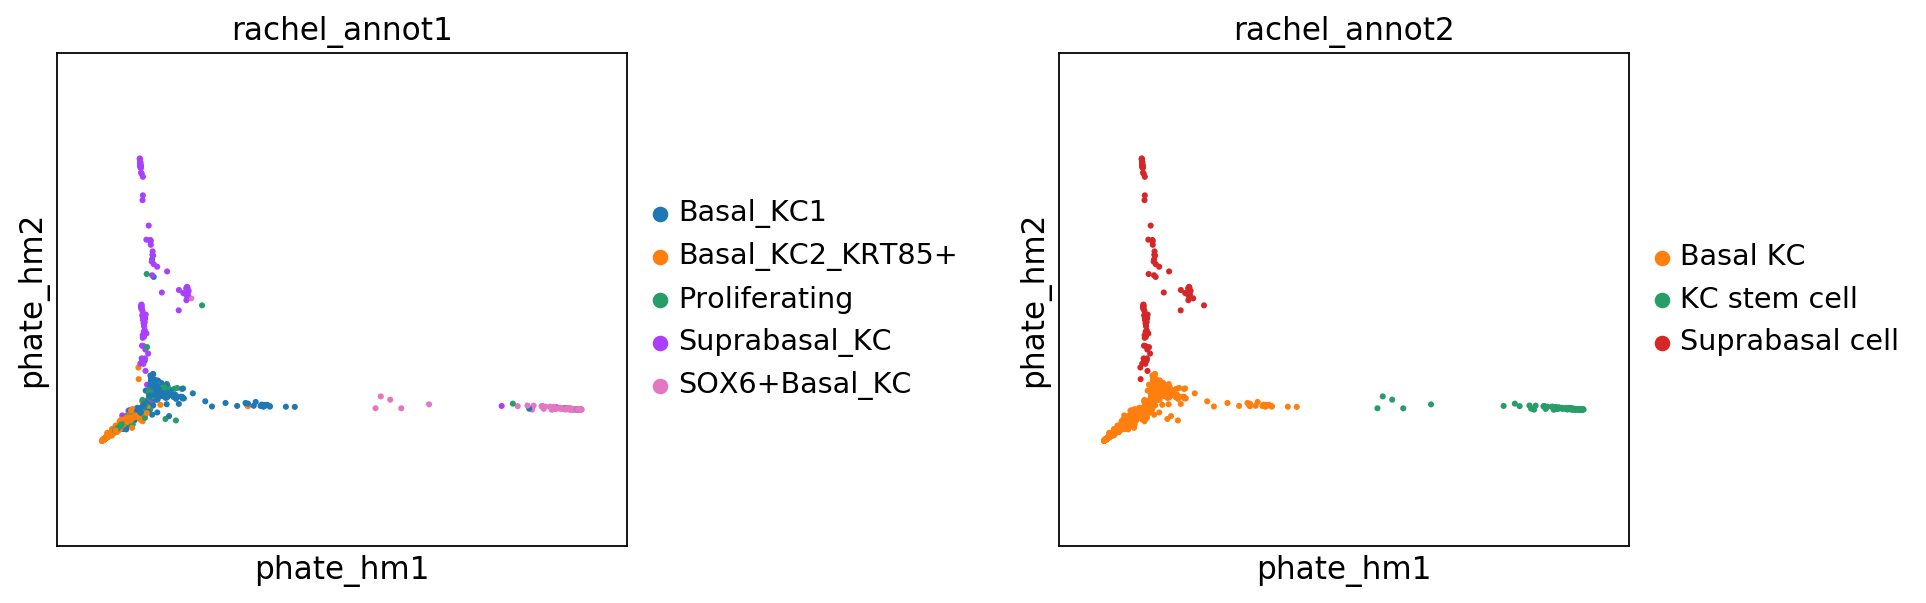

In [204]:
ss.lib.plot_scatter(ad_kc, basis='phate_hm', color=['rachel_annot1', 'rachel_annot2'], size=30, wspace=0.6, save='_keratinocytes.png')

In [208]:
ad_kc.uns['neighbors_bk'].keys()

dict_keys(['connectivities', 'distances', 'params'])

In [284]:
phate_operator = phate.PHATE(n_components=2, k=5, decay=10, t=150, knn_dist='precomputed_affinity', random_state=0)
ad_kc.obsm['X_phate_hm2'] = phate_operator.fit_transform(ad_kc.uns['neighbors_hm']['connectivities'])

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 1301 cells.
  Calculating graph and diffusion operator...
  Calculating diffusion potential...
  Calculated diffusion potential in 0.29 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.82 seconds.
Calculated PHATE in 2.12 seconds.


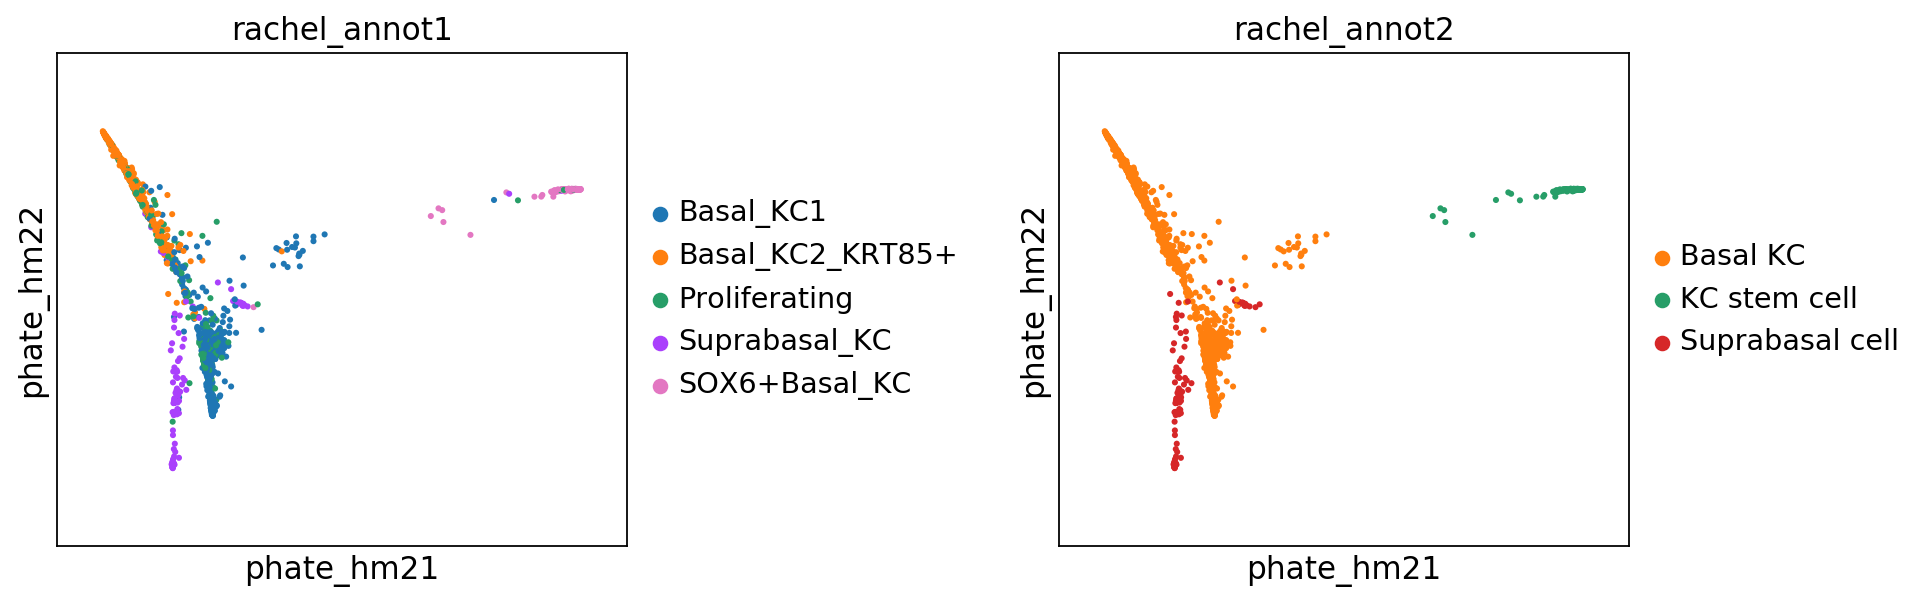

In [306]:
ss.lib.plot_scatter(ad_kc, basis='phate_hm2', color=['rachel_annot1', 'rachel_annot2'], size=30, wspace=0.6)

#### Neutrophiles

In [199]:
phate_operator = phate.PHATE(n_components=2, k=5, decay=20, t=50, n_pca=10, random_state=0)
np_phate = phate_operator.fit_transform(ad_np.obsm['X_pca_hm'])
ad_np.obsm['X_phate_hm'] = np_phate

Calculating PHATE...
  Running PHATE on 224 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.01 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.03 seconds.
Calculated PHATE in 0.06 seconds.


saving figure to file png/phate_hm_neutrophiles.png


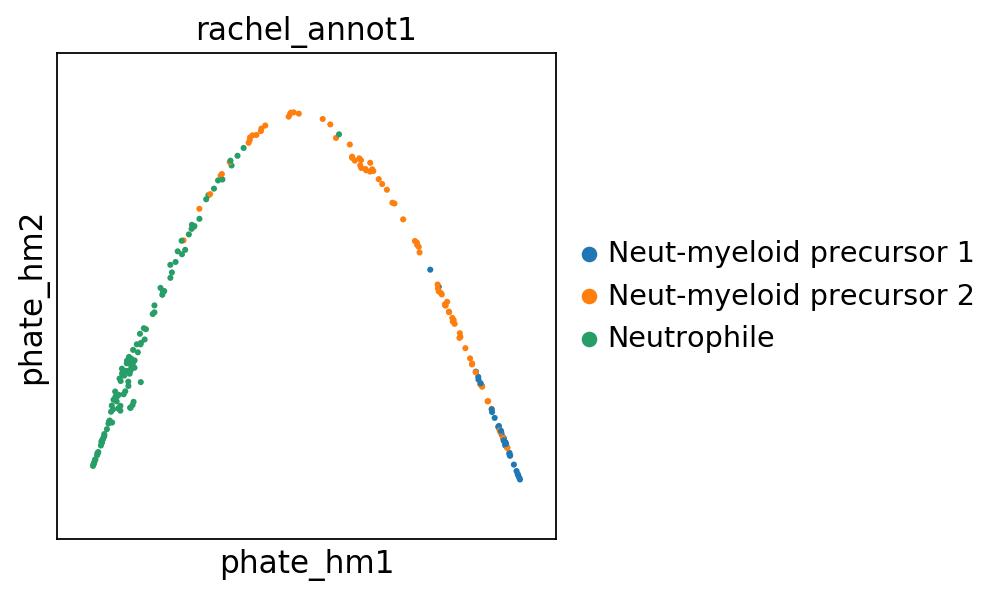

In [205]:
ss.lib.plot_scatter(ad_np, basis='phate_hm', color=['rachel_annot1'], size=30, save='_neutrophiles.png')

In [299]:
phate_operator = phate.PHATE(n_components=2, k=10, decay=50, t=10, knn_dist='precomputed_affinity', random_state=0)
ad_np.obsm['X_phate_hm2'] = phate_operator.fit_transform(ad_np.uns['neighbors_hm']['connectivities'])

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 224 cells.
  Calculating graph and diffusion operator...
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.03 seconds.
Calculated PHATE in 0.04 seconds.


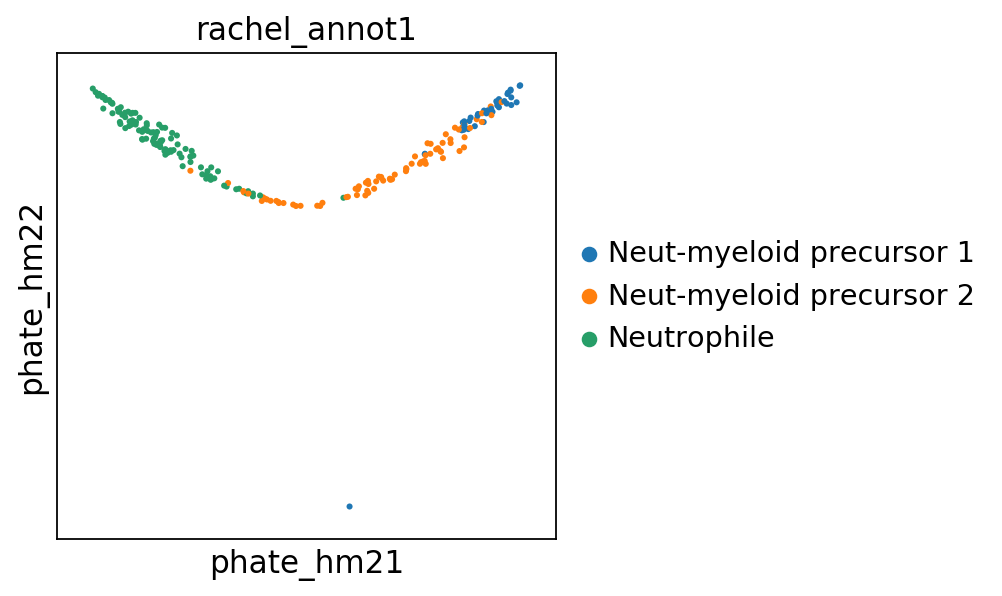

In [305]:
ss.lib.plot_scatter(ad_np, basis='phate_hm2', color='rachel_annot1', size=30, wspace=0.6)

In [201]:
phate_operator = phate.PHATE(n_components=2, k=5, decay=20, t=50, n_pca=100, random_state=0)
np_phate2 = phate_operator.fit_transform(ad_np2.obsm['X_pca_hm'])
ad_np2.obsm['X_phate_hm'] = np_phate2

Calculating PHATE...
  Running PHATE on 509 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.04 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.19 seconds.
Calculated PHATE in 0.25 seconds.


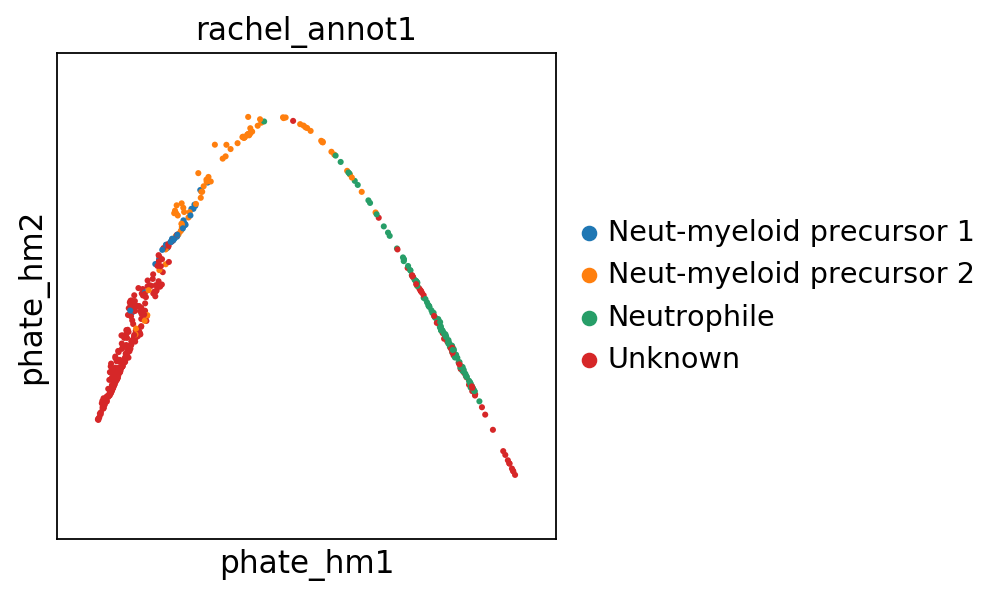

In [304]:
ss.lib.plot_scatter(ad_np2, basis='phate_hm', color='rachel_annot1', size=30, wspace=0.6)

### 3. Write h5ad with updated annotation

In [311]:
outdir = '../data/h5ad/20200114'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
for ct, ad in ads.items():
    print(ct)
#     print(ad.obs['rachel_annot2'].cat.categories)
    ad.write(f'{outdir}/fetal_skin.{ct}.doublet_removed_processed.20200114.h5ad', compression='lzf')

melanocytes
erythroid
keratinocytes
mast_cells
lymphoid_B
endothelium
lymphoid_T_NK
myeloid
stroma
neutrophiles
